# Introduction -- Reminder

Each Python lab will start with a pre-flight exercise that walks through building some of the set up and tools ($\sim$ 30 min), followed by an in-class tutorial with time for Q+A (50 min) so you can walk through steps that will be necessary for the homework assignment you will submit ($\sim$ 3 hrs).  Each lab will contain starter code, similar to what you see below.  Please fill in the code to complete the pre-flight assignment in preparation for the in-class tutorial.  

Preflight ($\sim$30-60 min, 10 points) **Typically due: Wednesdays 3pm EST**

*Preflight typically graded by Wednesday 5p EST*

In-class tutorial and Q+A ($\sim$ 50 min, 10 points) **Typically occurs: Thursdays 9am EST**

Homework assignment ($\sim$ 3-5 hrs, 30 points) **Typically due: Mondays 9am EST** 

*Homework typically graded by Thursday 5p*

When we grade your homework, we will not run your code. Once submitted, your notebook should have the outputs for all of your results.  Please do not include long outputs from debugging, beyond a few print statements and the requested visualizations (i.e. plots).

**Grading:** When we grade your notebook, we will convert the .ipynb file to an HTML file.  We will be using [nbgrader](https://nbgrader.readthedocs.io/en/stable/) to grade your notebooks.  **Note:** If your ```IPython``` version is too old, we will *not* be able to grade your assignments.


# Phys 260 Python Lab 5: Simulating an RC circuit (30 points total)

## Tutorial/HW summary
- Review of python classes with the mechanics analog: the spring
- Setting up the RC circuit

## Equations of Motion:  Numerically solving differential equations

The main topic this week has been an introduction to circuit components: resistors, capacitors, and current.  This coming week will go over how different combinations of circuit components impact the time dependence of the system.  Most simple circuits can be solved using a variety of techniques.  More complex circuits, or more complex input signal, do not have easy paths to an exact solution.

From lecture, we know that the current is defined as the charge flow per unit time, a differential equation:
\begin{equation}
I = \frac {dQ} {dt}
\end{equation}

We can solve differential equations numerically. 

Consider a first-order equations of the form:
\begin{equation}
\frac {dx} {dt} = f(x,t).
\end{equation}

The solution to this equation is a function $x(t)$ whose first derivative is $f$.
To find the solution to such an equation, we also need boundary conditions, or starting points.  Suppose that we have a first-order differential equation and know the value of $x$ for some specific time $t$, that is we know $x(t)$.  The we can write the value of x some short time later as
\begin{equation}
x(t+h) = x(t) + h \frac {dx} {dt} + \frac 1 2 h^2 \frac {d^2x} {dt^2} + ...
\end{equation}

\begin{equation}
x(t+h) = x(t) + h f(x,t) + h^2 \frac {df(x,t)} {dt} + ...
\end{equation}

If $h$ is small then $h^2$ is really small, and we can ignore it, and all higher terms of $h^n$.  This technique is called Euler's method.

Using this, if we know the value of $x$ at some time $t$ we can find the value at some short time later.  We can then repeat this process and understand how $x$ changes over time. The set of $x$ values at a discrete set of $t$ values is the numerical solution to our differential equation.

We are going to use this method to find the current, voltages and charges in simple circuits.  We will start with circuits which are easy to solve analytically so we can verify the numerical solution. Later we'll consider circuits that are a little more difficult.


In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Example from Mechanics: the Simple Harmonic Oscillator

To illustrate these ideas, let's work out the solution to a situation with which you are already familiar: the simple harmonic oscillator, e.g. a mass on a spring:
<img src="http://www-personal.umich.edu/~gerdes/img/SHO.png" height="300" align="center">
This system is described by Newton's second law:
$$
    F = ma = m\frac{d^2x}{dt^2}= -kx.
$$

This is a second-order differential equation (it relates the function $x(t)$ to its second derivative), so we need to specify two boundary conditions. In mechanics, boundary conditions are often the initial position and velocity. 

Let's suppose that the mass starts from rest at $x_0=x(t=0)=1$. We know that the solution to Newton's second law is
\begin{eqnarray}
        x(t)& = & A\cos\omega t \\
        v(t) & = &-A\omega\sin\omega t \\
        a(t)& = &-A\omega^2\cos\omega t,
\end{eqnarray}
where $\omega = \sqrt{k/m}$, and in this case $A=1$.

In discrete form, our equations look like:
$$
    \Delta v = a\Delta t,
$$
$$
    \Delta x = v\Delta t.
$$

Let us also assume that there is some viscous damping or friction that the mass experiences leading to a damping term, $cv$, that manifests in Newton's 2nd law as,
\begin{eqnarray}
    m\frac{d^2x}{dt^2}+c\frac{dx}{dt}+kx = 0\\
    ma + cv + kx = 0
\end{eqnarray}

Note, the acceleration depends on both the position and velocity as,
\begin{eqnarray}
    a = -cv/m - \omega x
\end{eqnarray}

Since it is a damping term, let us consider a damping coefficient of $c/m=0.1$.  To later test our code for a frictionless surface, we can set $c/m = 0$.

Then we can proceed as follows:
- Define constants that initialize the spring system (i.e. initialize the state of the spring)
- Define the equations of motion
- Time evolve the system

We will do this with a `Spring` class.

In [22]:
class Spring : 
    def __init__(self, mass, spring_k, x0=1, v0=0, damping_c=0.1) :
        self.x_now = x0
        self.v_now = v0
        self.a_now = -damping_c*v0 - spring_k * x0
        self.damping_c = damping_c
        self.spring_k = spring_k

        # Define the attributes omega (cycles per time) and the period (units of time) below
        ### BEGIN SOLUTION
        self.omega = np.sqrt(spring_k/mass)
        self.period = 2*np.pi/self.omega
        ### END SOLUTION
        
        self.x_vals = []
        self.v_vals = []
        self.a_vals = []
        
    def evolve_spring(self, num_periods, num_timesteps_per_period) :

        dt = self.period / num_timesteps_per_period

        try :
            if self.dt != dt :
                # self.dt already exists, using evolve_spring with a different one
                print("Warning: you are continuing with a different timestep")
                self.dt = dt
        except AttributeError :
            # Define the attribute dt for the first time
            self.dt = dt    
        
        num_timesteps = num_periods * num_timesteps_per_period
        
        for timestep in np.arange(num_timesteps) :
            # Populate
            self.a_vals.append(self.a_now)
            self.v_vals.append(self.v_now)
            self.x_vals.append(self.x_now)

            # Update
            self.a_now = -self.damping_c*self.v_now - self.spring_k * self.x_now
            self.v_now += self.a_now*dt
            self.x_now += self.v_now*dt

In [23]:
#  Create an instance of the spring and chage its state with time evolution
spring = Spring(1,1)

num_periods = 5
num_timesteps_per_period = 1000
spring.evolve_spring(num_periods, num_timesteps_per_period)

We plot with respect to time in units of period.

Text(0.5, 0, 'Time in units of period')

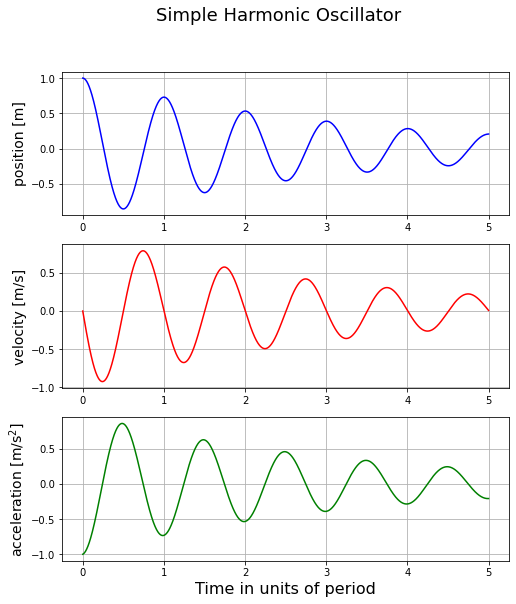

In [24]:
num_timesteps = len(spring.x_vals)
time_period_units = np.arange(num_timesteps) * spring.dt / spring.period

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,9))
fig.suptitle('Simple Harmonic Oscillator', fontsize=18)

ax1.plot(time_period_units, spring.x_vals, color='b')
ax1.grid()
ax1.set_ylabel('position [m]', fontsize=14)

ax2.plot(time_period_units, spring.v_vals, color='r')
ax2.grid()
ax2.set_ylabel('velocity [m/s]', fontsize=14)

ax3.plot(time_period_units, spring.a_vals, color='g')
ax3.grid()
ax3.set_ylabel('acceleration [m/s$^2$]', fontsize=14)
ax3.set_xlabel('Time in units of period', fontsize=16)

In [25]:
#  Continue evolving for three more periods
num_periods = 3
num_timesteps_per_period = 1000
spring.evolve_spring(num_periods, num_timesteps_per_period)

Text(0.5, 0, 'Time in units of period')

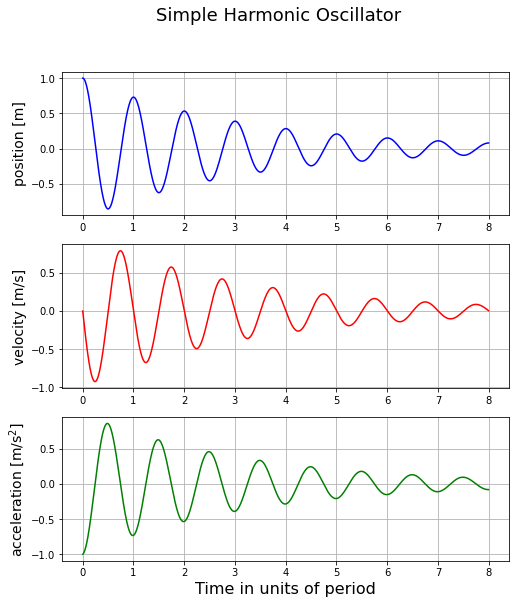

In [28]:
#  Your code using zip to make same plot as above here:
num_timesteps = len(spring.x_vals)
time_period_units = np.arange(num_timesteps) * spring.dt / spring.period

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,9))  
axes = [ax1, ax2, ax3]

fig.suptitle('Simple Harmonic Oscillator', fontsize=18)
yarrays = [spring.x_vals, spring.v_vals, spring.a_vals]
ylabels = ['position [m]', 'velocity [m/s]', 'acceleration [m/s$^2$]']
colors = ['b', 'r', 'g']

for ax, yarray, ylabel, color in zip(axes, yarrays, ylabels, colors) :
    ax.plot(time_period_units, yarray, color=color)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=14)

ax3.set_xlabel('Time in units of period', fontsize=16)

In [29]:
#  Evolve for one period with a different timestep
num_periods = 3
num_timesteps_per_period = 2000
spring.evolve_spring(num_periods, num_timesteps_per_period)

Text(0.5, 0, 'Time in units of period')

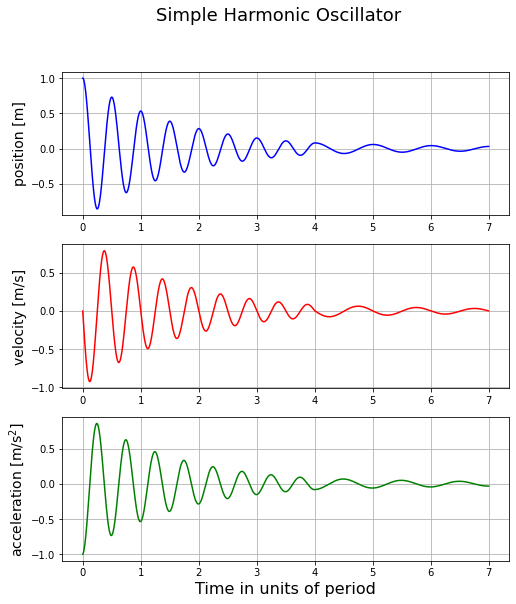

In [30]:
#  Your code using zip to make same plot as above here:
num_timesteps = len(spring.x_vals)
time_period_units = np.arange(num_timesteps) * spring.dt / spring.period

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,9))  
axes = [ax1, ax2, ax3]

fig.suptitle('Simple Harmonic Oscillator', fontsize=18)
yarrays = [spring.x_vals, spring.v_vals, spring.a_vals]
ylabels = ['position [m]', 'velocity [m/s]', 'acceleration [m/s$^2$]']
colors = ['b', 'r', 'g']

for ax, yarray, ylabel, color in zip(axes, yarrays, ylabels, colors) :
    ax.plot(time_period_units, yarray, color=color)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=14)

ax3.set_xlabel('Time in units of period', fontsize=16)

## Build a class for the rc-circuit

In [ ]:
class RCCircuit :
    def __init__(self) :
        self.R
        self.C
        self.V
        self.Q